<a href="https://colab.research.google.com/github/albertaillet/CLIPLSD/blob/colab-setup/notebooks/experiment4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys; sys.version

'3.7.12 (default, Sep 10 2021, 00:21:48) \n[GCC 7.5.0]'

## Setup
Restart the runtime after running this.

* Clone repo and from correct branch

* Download the pretrained stylegan2 model from https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/

* Install requirements

* Update github repo

In [ ]:
import os
if "CLIPLSD" not in os.getcwd():
  if "CLIPLSD" not in os.listdir():
    !git clone --branch colab-setup https://github.com/albertaillet/CLIPLSD/
    !wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -P CLIPLSD/pretrained/stylegan2
    !gdown --id 154JgKpzCPW82qINcVieuPH3fZ2e0P812 -O CLIPLSD/pretrained/face_bisenet/model.pth
    !pip install git+https://github.com/openai/CLIP.git
    !pip install -r CLIPLSD/requirements.txt
    !!npm install -g localtunnel
  %cd CLIPLSD/
%ls

/content/CLIPLSD
apps/       environment.yml  models/     pretrained/   requirements.txt
cliplsd.py  lelsd.py         notebooks/  __pycache__/  utils/
Dockerfile  LICENSE          out/        readme.md


In [ ]:
!git pull

Already up to date.


## Tensorboard

In [ ]:
%load_ext tensorboard

In [ ]:
%cd /content/CLIPLSD

/content/CLIPLSD


In [ ]:
%tensorboard --logdir out

## Imports

In [ ]:
%cd /content/CLIPLSD
#%load_ext autoreload
#%autoreload 2

# import warnings
# warnings.filterwarnings("ignore")
import sys
import glob
import torch
from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
import numpy as np
import cv2
from IPython.display import Image 

import clip
import models
from utils.stylegan2_utils import StyleGAN2SampleGenerator
from utils.segmentation_utils import FaceSegmentation
from cliplsd import CLIPLSD

/content/CLIPLSD


In [ ]:
device = torch.device('cuda')

exp_dir = "out"
clip_model_name = "ViT-B/32"
G2 = models.get_model("stylegan2", "pretrained/stylegan2/ffhq.pkl")
sample_generator = StyleGAN2SampleGenerator(G=G2, device=device)
clip_model, clip_preprocess = clip.load(clip_model_name)

# face_bisenet = models.get_model("face_bisenet", "pretrained/face_bisenet/model.pth")
# face_segmentation = FaceSegmentation(face_bisenet=face_bisenet, device=device)
# arcface = models.get_model("arcface", model_name='r50', model_path='pretrained/arcface/ms1mv3_arcface_r50_fp16.pth').to(device)

## Training

In [ ]:
%rm out/ -r

In [ ]:
%cd /content/CLIPLSD

/content/CLIPLSD


In [ ]:
seeds = list(range(1, 21))
seeds

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

In [ ]:
args = {
        "latent_space": "W",
        "semantic_text": "a photo of a person with gray hair",
        "num_latent_dirs": 1,
        "learning_rate": 0.001,
        "min_alpha_value": 0,
        "max_alpha_value": 1.0,
        "min_abs_alpha_value": 0.1,
        "l2_lambda": 0.0,
        "id_lambda": 0.0,
        "localization_lambda": 0.0,
        "batch_size": 2,
}
log_dir = f'{exp_dir}/cliplsd_stylegan2_ffhq/{args["latent_space"]}/{args["num_latent_dirs"]}D/{clip_model_name.replace("/", "-")}/{args["semantic_text"]}/single_seed/'

In [ ]:
for single_seed in seeds[1:]:
  lelsd = CLIPLSD(device,
                  **args,
                  n_layers=18,
                  latent_dim=512,
                  unit_norm=False,
                  log_dir=log_dir + f"{single_seed}",
                  )
  lelsd.fit(sample_generator, clip_model, num_batches=200 * args["num_latent_dirs"],
            num_lr_halvings=3, snapshot_interval=20,
            pgbar=True, summary=True, single_seed=single_seed)
  lelsd.save()

100%|██████████| 200/200 [02:18<00:00,  1.45it/s]


In [ ]:
np.random.seed(seeds[0])
eval_seeds = np.random.randint(0, 10000, (50,))
seeds, eval_seeds

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 array([ 235, 5192,  905, 7813, 2895, 5056,  144, 4225, 7751, 3462, 9394,
        5396, 5374, 2962, 2516, 8444, 3562, 4764, 8093, 6542,  562, 8151,
        3049,  753, 9719, 1888, 1110, 6285, 6121, 1031, 4415, 2877, 3606,
        9529, 2561, 8920, 6771,  431, 4074,  542, 9287, 1478, 1337, 7108,
        8689, 1612, 3098, 1844, 9552, 2669]))

In [ ]:
import re
eval_list = []
self_list = []

for path in glob.glob(log_dir + "/*/*/model.pth"):
  single_seed = int(re.search(r"(?<=single_seed/)[\d]+", path).group(0))
  
  lelsd = CLIPLSD.load(path)
  eval_score_list = []
  self_score_list = []

  print(single_seed)

  for alpha in trange(10):
    scores = lelsd.score_seeds(sample_generator, clip_model, eval_seeds, alpha, batch_size = 4).cpu().numpy()
    self_score = lelsd.score_seeds(sample_generator, clip_model, [single_seed], alpha, batch_size = 4).cpu().numpy()
    eval_score_list.append(scores)
    self_score_list.append(self_score)
  
  eval_list.append(eval_score_list)
  self_list.append(self_score_list)

9


  0%|          | 0/10 [00:00<?, ?it/s]

4


  0%|          | 0/10 [00:00<?, ?it/s]

10


  0%|          | 0/10 [00:00<?, ?it/s]

17


  0%|          | 0/10 [00:00<?, ?it/s]

20


  0%|          | 0/10 [00:00<?, ?it/s]

3


  0%|          | 0/10 [00:00<?, ?it/s]

5


  0%|          | 0/10 [00:00<?, ?it/s]

15


  0%|          | 0/10 [00:00<?, ?it/s]

12


  0%|          | 0/10 [00:00<?, ?it/s]

7


  0%|          | 0/10 [00:00<?, ?it/s]

6


  0%|          | 0/10 [00:00<?, ?it/s]

11


  0%|          | 0/10 [00:00<?, ?it/s]

18


  0%|          | 0/10 [00:00<?, ?it/s]

2


  0%|          | 0/10 [00:00<?, ?it/s]

19


  0%|          | 0/10 [00:00<?, ?it/s]

1


  0%|          | 0/10 [00:00<?, ?it/s]

14


  0%|          | 0/10 [00:00<?, ?it/s]

8


  0%|          | 0/10 [00:00<?, ?it/s]

13


  0%|          | 0/10 [00:00<?, ?it/s]

16


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
seeds, eval_seeds

([1, 2, 3],
 array([ 235, 5192,  905, 7813, 2895, 5056,  144, 4225, 7751, 3462, 9394,
        5396, 5374, 2962, 2516, 8444, 3562, 4764, 8093, 6542]))

In [ ]:
eval_np = np.array(eval_list)
self_np = np.array(self_list)
eval_np.shape, self_np.shape # shape: train_seed, alpha, dir-change, score_seed

((20, 10, 2, 50), (20, 10, 2, 1))

In [ ]:
(eval_np[:, :, 1] - eval_np[:, :, 0]).shape

(1, 10, 100)

In [ ]:
np.save('plot_1-20_eval', eval_np)
np.save('plot_1-20_self', self_np)

Text(0, 0.5, 'Change in CLIP similarity')

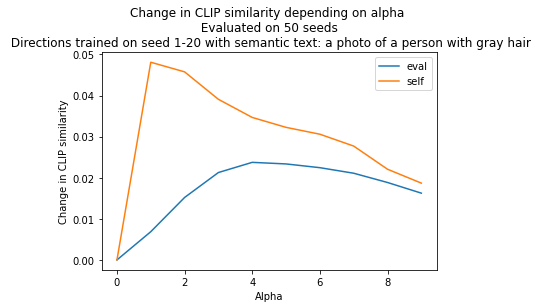

In [ ]:
text = "a photo of a person with gray hair"
plt.plot((eval_np[:, :, 1] - eval_np[:, :, 0]).mean(axis=2).mean(axis=0), label="eval")
plt.plot((self_np[:, :, 1] - self_np[:, :, 0]).mean(axis=2).mean(axis=0), label="self")
plt.legend()
# plt.yscale('log')
plt.title(f'Change in CLIP similarity depending on alpha \n Evaluated on {len(eval_seeds)} seeds \n Directions trained on seed 1-20 with semantic text: {text}')
plt.xlabel('Alpha')
plt.ylabel('Change in CLIP similarity')


# Generate animation

In [52]:
cliplsd = CLIPLSD.load("/content/CLIPLSD/out/cliplsd_stylegan2_ffhq/W/1D/ViT-B-32/a photo of a person with gray hair/single_seed/1/Jun02_16-07-32/model.pth")

In [66]:
import torchvision
from PIL import Image

batch = sample_generator.generate_batch(seed=1, return_image=True, batch_size=1)

In [68]:
images = []
for alpha in tqdm(np.linspace(0, 10, 100)):
  alpha += 0.5
  edit_batch = cliplsd.edit_batch_data(sample_generator, batch, 0, alpha=alpha)
  images.append(edit_batch["image"][0])

  0%|          | 0/100 [00:00<?, ?it/s]

In [65]:
cliplsd.log_dir

'out/cliplsd_stylegan2_ffhq/W/1D/ViT-B-32/a photo of a person with gray hair/single_seed/1/Jun02_16-07-32'

In [89]:
gif_dir = f"/content/CLIPLSD/gif_images"
if not os.path.exists(gif_dir):
  os.makedirs(gif_dir)

for i, im in enumerate(images):
  im.save(os.path.join(gif_dir, f"{str(i).zfill(5)}.jpg"))

In [94]:
!ffmpeg -r 15 -i $gif_dir/%05d.jpg -c:v libx264 -vf fps=25 -pix_fmt yuv420p out.mp4
from google.colab import files
files.download('out.mp4')

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Debug Cells

In [ ]:
batch = sample_generator.generate_batch(seed=1, requires_grad=True, return_image=True)

In [ ]:
batch['raw_image'].size()

In [ ]:
upsample = torch.nn.Upsample(scale_factor=7)
average_pool = torch.nn.AvgPool2d(kernel_size=1024 // 32)
image_input = average_pool(upsample(batch['raw_image']))

In [ ]:
image_features = clip_model.encode_image(image_input).float().to(device)
image_features /= image_features.norm(dim=-1, keepdim=True)

In [ ]:
text_token = clip.tokenize("a person with glasses").to(device)
text_features = clip_model.encode_text(text_token).float().to(device)
text_features /= text_features.norm(dim=-1, keepdim=True)

In [ ]:
similarity = torch.matmul(text_features, image_features.t())

In [ ]:
(1 - similarity).mean()

In [ ]:
similarity.view(batch_size, -1)

# Run Streamlit app
click the "your url is: " url

In [ ]:
%cd /content/CLIPLSD/apps

/content/CLIPLSD/apps


In [23]:
!streamlit run 1D_visualization.py & npx localtunnel --port 8501


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.2:8501
  External URL: http://34.105.115.63:8501

npx: installed 22 in 2.509s
your url is: https://some-suits-yell-34-105-115-63.loca.lt
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
2022-06-02 18:23:05.837 Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/streamlit/scriptrunner/script_runner.py", line 475, in _run_script
    exec(code, module.__dict__)
  File "/content/CLIPLSD/apps/1D_visualization.py", line 156, in <module>
    random_seed = int(st.sidebar.text_input('Random seed for generating the image', value='1'))
ValueError: invalid literal for int() with base 10: ''

  Stopping...
^C


In [ ]:
torch.cuda.empty_cache()

# Download trianed models

In [ ]:
!zip -r /content/CLIPLSD/out.zip /content/CLIPLSD/out

In [ ]:
from google.colab import files

files.download('/content/CLIPLSD/out.zip')

In [ ]:
!ls & clear

1D_visualization.py  Baskerville.ttc	  sequential_editing.py
2D_visualization.py  model_comparison.py
